# Tooth and Cavity Instance Segmentation

In [491]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.datasets import (
    CocoDetection,
    wrap_dataset_for_transforms_v2
)
from torchvision.transforms import v2

from types import SimpleNamespace
from pathlib import Path
from pprint import pprint
from typing import Optional

In [109]:
FPATHS = SimpleNamespace(
    data = Path("../data/")
)

FPATHS.data_train = FPATHS.data / "train"
FPATHS.data_valid = FPATHS.data / "valid"
FPATHS.data_test = FPATHS.data / "test"

FPATHS.data_annotations_fname = "_annotations.coco.json"
FPATHS.data_train_annotations = FPATHS.data_train / FPATHS.data_annotations_fname
FPATHS.data_valid_annotations = FPATHS.data_valid / FPATHS.data_annotations_fname
FPATHS.data_test_annotations = FPATHS.data_test / FPATHS.data_annotations_fname


In [570]:
transforms = v2.Compose([
    v2.ToImagePIL(),
    v2.RandomPhotometricDistort(p=0.5),
    v2.SanitizeBoundingBox()
])

datasets = SimpleNamespace()
datasets.train = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_train,
    FPATHS.data_train_annotations,
    transforms=transforms
))

datasets.train_raw = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_train,
    FPATHS.data_train_annotations,
))

datasets.valid = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_valid,
    FPATHS.data_valid_annotations
)),

datasets.test = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_test,
    FPATHS.data_test_annotations
))

category_id_to_name = {
    0: "Null",
    1: "Caries",
    2: "Cavity",
    3: "Crack",
    4: "Tooth"
}

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [578]:
def plot_coco_image(
        dataset: Dataset,
        index: int = 0,
        plot_masks: bool = True,
        plot_bboxes: bool = True,
        plot_segmentations: bool = True,
        plot_category_id: bool = True,
        category_names: Optional[dict[int, str]] = None
    ):
    image, target = dataset[index]
    bboxes = target["bbox"]
    masks = target["masks"]
    segmentations = target["segmentation"]
    categories = target["category_id"]

    fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

    if plot_masks:
        for i, mask in enumerate(masks):
            ax.imshow(mask + 0.5 * i, alpha=mask * 0.25, cmap="Set2", vmin=0, vmax=len(masks) / 2)

    if plot_bboxes:
        for bbox in bboxes:
            x, y, width, height = bbox
            patch = matplotlib.patches.Rectangle(
                (x, y),
                width,
                height,
                alpha=1,
                fill=False,
                edgecolor="red",
                linewidth=1,
                mouseover=True
            )
            ax.add_patch(patch, )

    if plot_segmentations:
        for segmentation in segmentations:
            x = [val for i, val in enumerate(segmentation[0]) if i % 2 == 0]
            y = [val for i, val in enumerate(segmentation[0]) if i % 2 != 0]
            ax.plot(x, y, color="black")

    if plot_category_id:
        for i, bbox in enumerate(bboxes):
            x, y, width, height = bbox
            category_id = categories[i]

            if category_names is not None:
                display_text = category_names[category_id]
            else:
                display_text = category_id
            
            ax.text(x+4, y-8, display_text, color="white", fontsize=6, backgroundcolor=(1, 0 ,0, 0.25))
        
        
    return fig
    

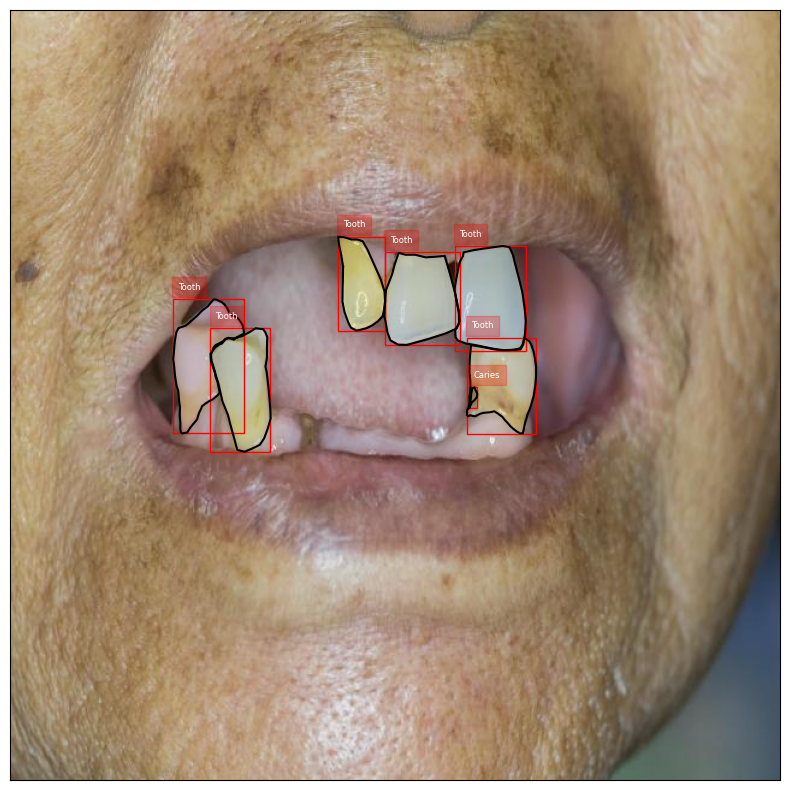

In [580]:
x = plot_coco_image(
    datasets.test,
    2,
    plot_masks=True,
    plot_bboxes=True,
    plot_segmentations=True,
    plot_category_id=True,
    category_names=category_id_to_name
)